In [2]:
import pandas as pd 
from src.data.loading import loading, sample
from src.data.cleaning import cleaning
from src.data.feature_engineering import dropping_constant_features
from src.data.splitting import train_val_test_split
from src.data.preprocessing import initial_preprocessing


In [3]:
from src.data.loading import loading

filepath = "/Users/thananpornsethjinda/Desktop/credit-risk-modeling/data/accepted_2007_to_2018Q4.csv"

raw_data = loading(file_path=filepath)

/Users/thananpornsethjinda/Desktop/credit-risk-modeling/src/data/loading.py:10: DtypeWarning: Columns (0: id, 1: desc, 2: next_pymnt_d, 3: verification_status_joint, 4: sec_app_earliest_cr_line, 5: hardship_type, 6: hardship_reason, 7: hardship_status, 8: hardship_start_date, 9: hardship_end_date, 10: payment_plan_start_date, 11: hardship_loan_status, 12: debt_settlement_flag_date, 13: settlement_status, 14: settlement_date) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(file_path)


Data successfully read in 29.42159676551819 seconds!


In [4]:
from src.data.loading import sample

sampled_raw_data = sample(raw_data)

In [5]:
from src.data.cleaning import cleaning

cleaned_sampled = cleaning(sampled_raw_data)

Starting data cleaning
Grouping target variable to binary targets (Charged Off) and (Fully Paid) ...
Dropping loan status null values
A total of 45 were dropped; with the columns being ['member_id', 'desc', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_rcnt_il', 'il_util', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_st

## Feature Engineering 

In [ ]:
# drop columns based on domain knowledge/irrelevant columns/columns that would cause data leakage (done in cleaing already)

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(cleaned_sampled)

X_train, X_val, X_test = initial_preprocessing(X_train=X_train, X_val=X_val, X_test=X_test)

In [8]:
## Dropping constant and quasi constant features 
from feature_engine.selection import DropConstantFeatures

sel = DropConstantFeatures(tol=0.95)

sel.fit(X_train)

X_train = sel.transform(X_train)
X_val = sel.transform(X_val)
X_test = sel.transform(X_test)

print(f"{len(sel.features_to_drop_)} Constant and Quasi-Constant features dropped; they are: {sel.features_to_drop_}; ")

12 Constant and Quasi-Constant features dropped; they are: ['pymnt_plan', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'tax_liens', 'disbursement_method', 'debt_settlement_flag']; 


In [9]:
# Correlation Analysis (found in seperate notebook)

corr_columns_drop = [
    'loan_amnt', 
    'funded_amnt_inv',
    'open_acc',
    'pub_rec_bankruptcies',
    'tot_hi_cred_lim',
    'avg_cur_bal',
    'total_bc_limit',
    'num_actv_bc_tl',
    'num_rev_tl_bal_gt_0',
    'num_bc_tl',
    'num_op_rev_tl',
    'percent_bc_gt_75',
    'total_il_high_credit_limit'
]

X_train.drop(corr_columns_drop, axis=1, inplace=True) # drop for the training set 
X_val.drop(corr_columns_drop, axis=1, inplace=True) # also drop for the test set 
X_test.drop(corr_columns_drop, axis=1, inplace=True) # also drop for the test set 

In [ ]:
# Statistical Tests 

In [10]:
grouped = X_train.merge(y_train, how='inner', left_index=True, right_index=True)

charged_off = grouped.loc[grouped['loan_status'] == 'Charged Off']

fully_paid = grouped.loc[grouped['loan_status'] == 'Fully Paid']

In [11]:
import scipy.stats as stats

# Mann-Whitney U test to test for correlation between the continuous features and the categorical targets 

# We establish the level of significance to be 5%

# Let the charged-off group be denoted by C 
# Let the fully paid group be denoted by F 

# H0: F_median = C_median (median of the fully paid group is the same as the median of the charged off group)

# H1: F_median != C_median (median of the fully paid group is the same as the median of the charged off group)

# So, if p-value < 0.05, we reject the null hypothesis to include that the medians are different so then 
# the correlation between that specific continuous feature and categorical target is significant 

columns_to_drop_from_mwu = []

for column in charged_off.select_dtypes(include=('float64')).columns: 
    stat, p_value = stats.mannwhitneyu(charged_off[column], fully_paid[column], alternative='two-sided')

    if p_value >= 0.05: 
        print(f"{column} to be dropped since p_value = {p_value}")
        columns_to_drop_from_mwu.append(column)

total_bal_il to be dropped since p_value = 0.44994146842076943
inq_fi to be dropped since p_value = 0.5966983463651203
num_il_tl to be dropped since p_value = 0.2210399539123198


In [ ]:
for column in X_train.select_dtypes(exclude=['float64']):

    contingency_table = pd.crosstab(grouped[column], grouped['loan_status'])

    chi2, p_value, degree_of_freedom, expected_values = stats.chi2_contingency(contingency_table)

    print(f"Column : {column}, p_value = {p_value}")

Column : term, p_value = 0.0
Column : sub_grade, p_value = 0.0
Column : emp_length, p_value = 0.0586028466066369
Column : home_ownership, p_value = 9.34144881495401e-109


In [15]:
X_train_imp_enc = X_train.copy()
X_val_imp_enc = X_val.copy()
X_test_imp_enc = X_test.copy()


ORDINAL_COLUMNS = ['sub_grade', 'emp_length']

ONE_HOT_COLUMNS = ['term', 'home_ownership']


from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

enc = OneHotEncoder(drop='first')

enc.fit(X_train_imp_enc[ONE_HOT_COLUMNS])

ONE_HOT_ENCODED_COLUMNS = list(enc.get_feature_names_out(ONE_HOT_COLUMNS))

X_train_imp_enc[ONE_HOT_ENCODED_COLUMNS] = enc.transform(X_train_imp_enc[ONE_HOT_COLUMNS]).toarray()

X_val_imp_enc[ONE_HOT_ENCODED_COLUMNS] = enc.transform(X_val_imp_enc[ONE_HOT_COLUMNS]).toarray()

X_test_imp_enc[ONE_HOT_ENCODED_COLUMNS] = enc.transform(X_test_imp_enc[ONE_HOT_COLUMNS]).toarray()


ordinal_enc = OrdinalEncoder()

ordinal_enc.fit(X_train_imp_enc[ORDINAL_COLUMNS])

ORDINAL_ENCODED_COLUMNS = list(ordinal_enc.get_feature_names_out(ORDINAL_COLUMNS))

X_train_imp_enc[ORDINAL_ENCODED_COLUMNS] = ordinal_enc.transform(X_train_imp_enc[ORDINAL_COLUMNS])

X_val_imp_enc[ORDINAL_ENCODED_COLUMNS] = ordinal_enc.transform(X_val_imp_enc[ORDINAL_COLUMNS])

X_test_imp_enc[ORDINAL_ENCODED_COLUMNS] = ordinal_enc.transform(X_test_imp_enc[ORDINAL_COLUMNS])

In [19]:
X_train_imp_enc = X_train_imp_enc.select_dtypes(exclude=['str'])
X_val_imp_enc = X_val_imp_enc.select_dtypes(exclude=['str'])
X_test_imp_enc= X_test_imp_enc.select_dtypes(exclude=['str'])

Text(0.5, 1.0, 'Mutual information between predictors and target')

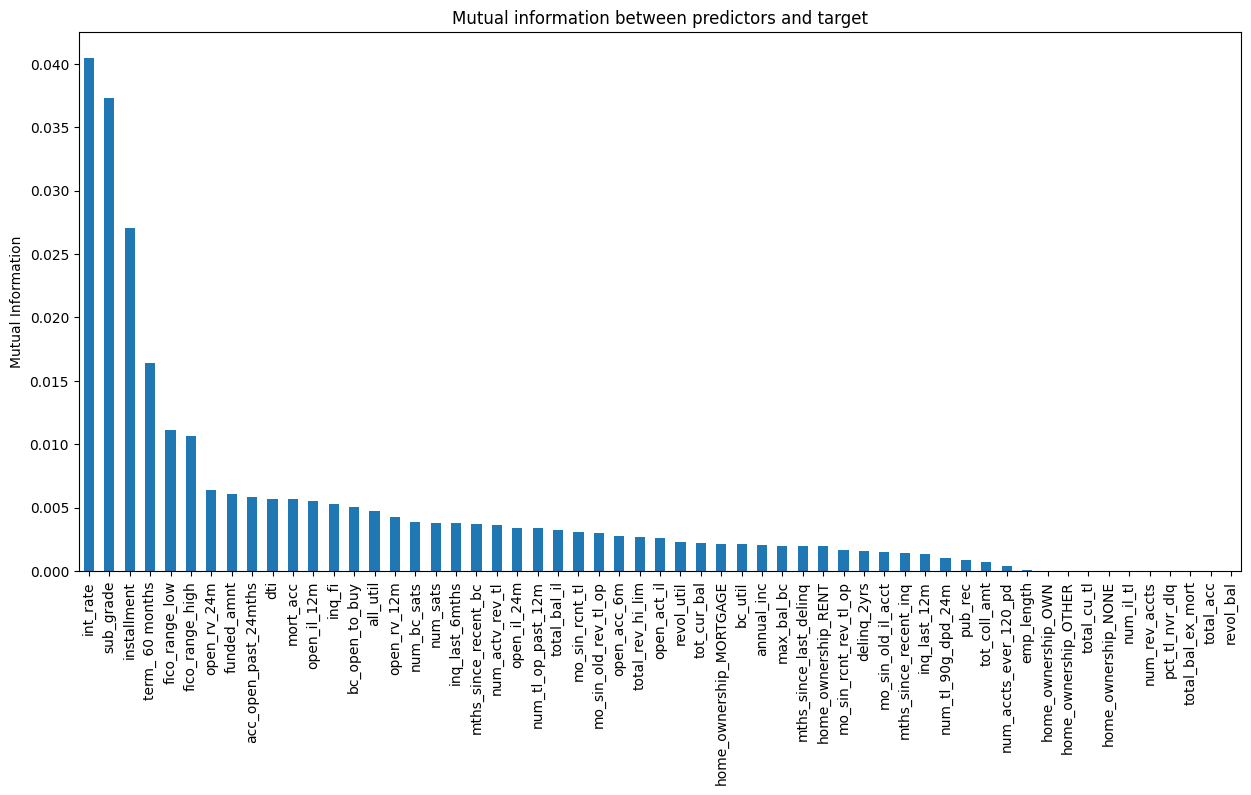

In [20]:
# Mutual information to test assoication between categorical and numerical features and the categorical targets
import matplotlib.pyplot as plt

masking = []
for column in X_train_imp_enc.columns: 
    if column in ONE_HOT_ENCODED_COLUMNS + ORDINAL_ENCODED_COLUMNS: 
        masking.append(True)
    else:
        masking.append(False)

from sklearn.feature_selection import mutual_info_classif

mi_stuff = mutual_info_classif(X_train_imp_enc, y_train, discrete_features=masking)

mi = pd.Series(mi_stuff)
mi.index = X_train_imp_enc.columns
mi.sort_values(ascending=False).plot.bar(figsize=(15, 7))
plt.ylabel('Mutual Information')
plt.title("Mutual information between predictors and target")

In [24]:
from sklearn.feature_selection import SelectKBest

X_train_final = X_train_imp_enc.copy()
X_val_final = X_val_imp_enc.copy()
X_test_final = X_test_imp_enc.copy()

sel = SelectKBest(lambda X, y: mutual_info_classif(X, y, discrete_features=masking), k=25)
sel.fit(X_train_final, y_train)

X_train_final = sel.transform(X_train_final)
X_val_final = sel.transform(X_val_final)
X_test_final = sel.transform(X_test_final)

X_train_final = pd.DataFrame(X_train_final, columns=sel.get_feature_names_out())
X_val_final = pd.DataFrame(X_val_final, columns=sel.get_feature_names_out())
X_test_final = pd.DataFrame(X_test_final, columns=sel.get_feature_names_out())